# Marketing Campaign Simulation Modeling

We would like to model if a bank client would buy an investment product.

In [1]:
import pandas as pd
try:
    from ggplot import *
except:
    !pip install ggplot
from ggplot.scales.scale_color_gradient import *
%matplotlib inline

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


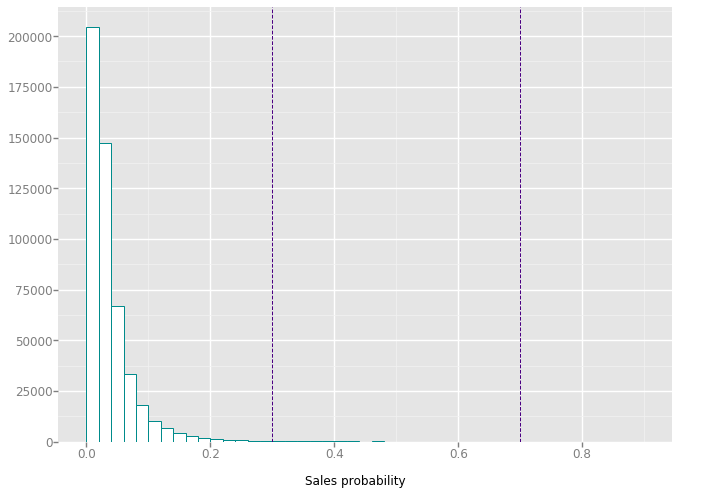

<ggplot: (19197872)>

In [2]:
data = pd.read_csv('sale_probability.csv')
ggplot(aes(x='Sales probability'), data=pd.DataFrame({ 'Sales probability' : data['probabilities'] })) \
    + geom_histogram(binwidth=0.02, color='darkcyan', fill="white") \
    + geom_vline(x=[0.30, 0.70], linetype='dashed', color="indigo")

We need to select a group of clients to be contacted, e.g., by phone, about the investment product. Our goal is to maximize sales (number of clients that buy the product) and minimize cost of contact (cost of contacting the client, e.g., salary of client representatives).

To achieve our goal we can simulate marketing campaign for the sales using probabilities of sales for each client that we have in the dataset. Simulation modeling would allow us to select parameters ${\rm min\_probability}$ and ${\rm max\_probability}$  that give us a list of clients that need to be contacted.

To enhance our model we can try compute if phone call to a client would increase or decrease a probability of sale (sales uplift) if we have data about previous contacts with clients. As we do not have it, we would choose a simple model of "uplift" - probability of sale will increase by 10% if a clients gets a call from the client representative.

Profit function from phone calls is:
$$profit=N_{sales}*avg(income_{sale})-N_{contacts}*avg(costs_{contact})$$
To enhace our simulation model we may use more complex model for costs of contact, e.g., fixed cost plus variable cost based on duration of phone calls.

In [3]:
import numpy.random as rnd
import numpy as np

In [4]:
result = []
def monte_carlo_coin(probability):
    r = rnd.uniform()
    return int(r < probability)

def profit(n_sales, n_contacts):
    avg_income_sale = 10.0
    avg_costs_contact = 2.0
    return n_sales*avg_income_sale - n_contacts*avg_costs_contact

In [5]:
monte_carlo_coin(0.9)

1

In [6]:
data.head()

,probabilities
0,0.032355
1,0.033055
2,0.012665
3,0.037067
4,0.016160


In [7]:
for min_probability in np.arange(0.0,0.9,0.1):
    for max_probability in np.arange(min_probability+0.1,1.0,0.1):
        # uplift
        target_group = data.probabilities.between(min_probability, max_probability)
        data_after_contact = data.copy()
        data_after_contact.ix[target_group, 'probabilities'] = data.ix[target_group].probabilities + 0.1
        
        prof = 0
        for _ in range(10):
            # simulation
            data_after_contact['sales'] = data_after_contact['probabilities'].apply(monte_carlo_coin)

            # results
            sales = data_after_contact['sales'].sum(axis=0)
            calls = target_group.sum(axis=0)
            prof += profit(sales, calls)
        prof /= 10
        result.append((min_probability, max_probability, sales, calls, prof))

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [8]:
best_results = sorted(result, key=lambda x: x[4])
best_results[-1]

(0.5, 0.7999999999999999, 18699, 215, 186923.0)

In [9]:
best_results[-3::1]

[(0.6000000000000001, 0.8, 18551, 77, 186776.0),
 (0.4, 0.6, 18722, 439, 186917.0),
 (0.5, 0.7999999999999999, 18699, 215, 186923.0)]

As a result we get a target group of clients to contact. The target group has middle ranges of probability values, namely 0.4 to 0.8 (smallest ${\rm min\_probability}$ and largest ${\rm max\_probability}$ among three best results) as clients with small probability values would not buy the product even if they get a phone call, while clients with high probability fo sale already decided to buy a product and the phone call would not help.

<class 'ggplot.scales.scale_color_gradient.scale_color_gradient'>


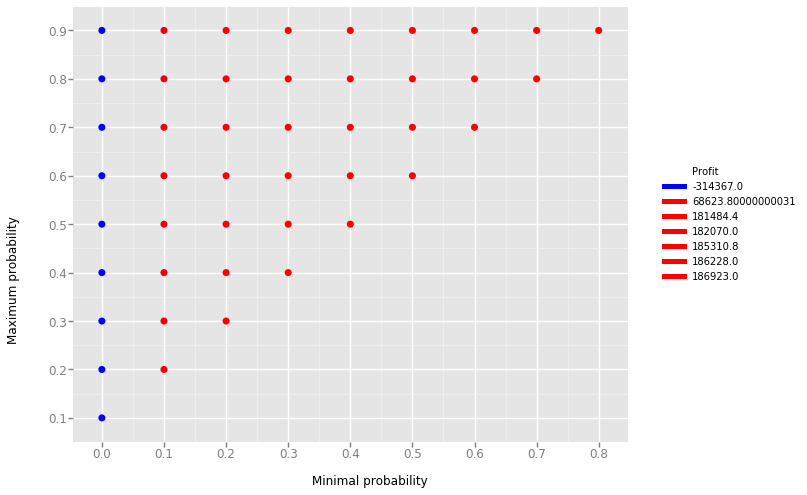

<ggplot: (19382024)>

In [11]:
vis = pd.DataFrame(result, columns=['Minimal probability', 'Maximum probability', 'No of sales', 'No of calls', 'Profit'])
print (scale_color_gradient)
ggplot(vis, aes(x='Minimal probability', y='Maximum probability', color='Profit')) + \
    geom_point(size=50) + \
    scale_color_gradient(low='blue', high='red')